In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
import matplotlib
%matplotlib inline

### Visulize kernels in an array

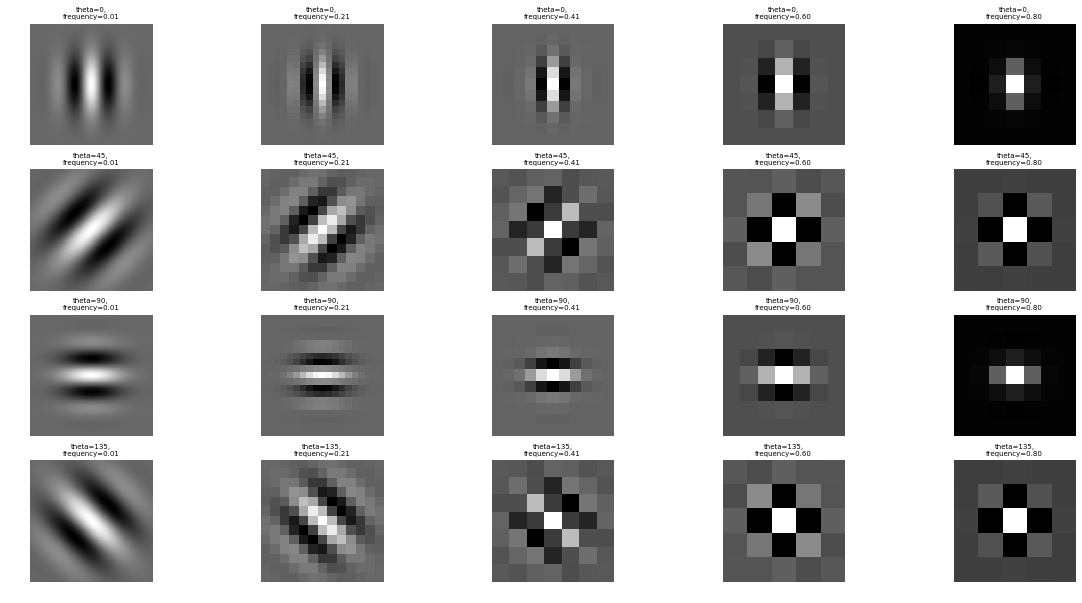

In [2]:
kernels = []
kernel_params = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for frequency in np.linspace(0.01,0.8,5,endpoint=True):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        kernels.append(kernel)

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 10))
plt.gray()
for label, kernel, ax_row in zip(np.array(kernel_params).reshape(4,5), np.array(kernels).reshape(4,5), axes):
    # Plot Gabor kernel
    for lab, ker, ax in zip(label, kernel, ax_row):
        ax.imshow(np.real(ker), interpolation='nearest')
        ax.set_title(lab, fontsize=7)
        ax.axis('off')

        

plt.show()
#plt.ion()

### Load 8 MSI images

In [3]:
### Set directory to image file location
import os
import glob
imagePath = "/Users/Lu/Desktop/SMD/Data/2014 May/Pig 1/1stDay_Pig1_MSI/1stday/1a_burn_24_TIFF/Images/2014-05-20_11.05.13/"
os.chdir(imagePath)

from PIL import Image
#im=[]
#for i in range(8):
#    im=im.append("*F{}*".format(i))
im=["*F{}*".format(i) for i in range(1,9)]   

shrink = (slice(0, None, 10), slice(0, None, 10)) # down sample by 10
#F=[]
#for i in im:
#    F.append(img_as_float(data.load(imagePath+glob.glob(i)[0]))[shrink]) #F size 8*1044*1408
F=[img_as_float(data.load(imagePath+glob.glob(i)[0]))[shrink] for i in im]

image_names =["F{}".format(i) for i in range(1,9)]  

### Mutiply kernel with MSI images

In [4]:
def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

# Plot a selection of the filter bank kernels and their responses.
results = [] # save both filtered output and kernel
kernel_params = []
gbfiltered=[] # just same the filtered output
for theta in range(4):
    theta = theta / 4. * np.pi
    for frequency in np.linspace(0.1,0.8,3,endpoint=True):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(im, kernel) for im in F]))
        gbfiltered.append([power(im, kernel) for im in F])

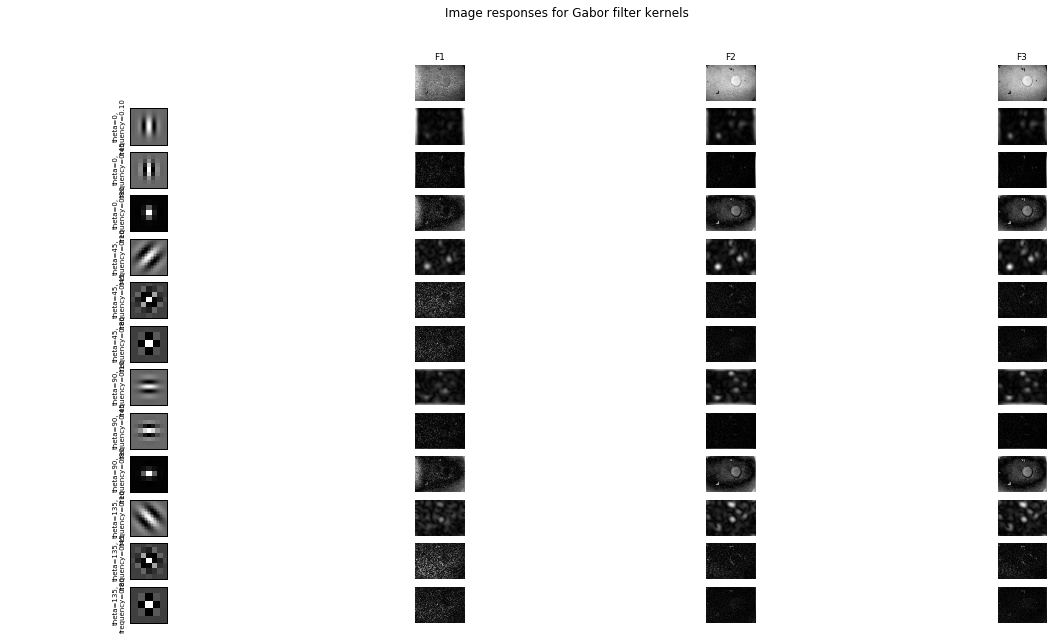

In [5]:
fig, axes = plt.subplots(nrows=13, ncols=4, figsize=(20, 10))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')
# Plot original images
for label, img, ax in zip(image_names, F, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel), interpolation='nearest')
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(powers)
    vmax = np.max(powers)
    for patch, ax in zip(powers, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')

plt.show()
#plt.ion()

### Gabor filtered image of one MSI

In [6]:
F1filtered=[]
Ffiltered=[]
sigma=[]
for theta in range(4):
    theta = theta / 4. * np.pi
    for frequency in np.linspace(0.1,1,3,endpoint=True):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        F1filtered.append(power(F[0], kernel)) #12*L*W
        Ffiltered.append([power(im, kernel) for im in F])   # F=12*8*L*W
        # http://www.mathworks.com/help/images/texture-segmentation-using-gabor-filters.html?refresh=true
        sigma.append(3*0.5*1/frequency) # all the frequency values # length(12)
                                      # sigma for gaussian filter=3*0.5*wavelength (wavelength=1/freq)

In [ ]:
#Ffiltered[0][0]=F1filtered[0]=F1Gb[0] (F1Gb=Ffiltered[:][0])

### Gaussian smoothing one gabor filtered MSI

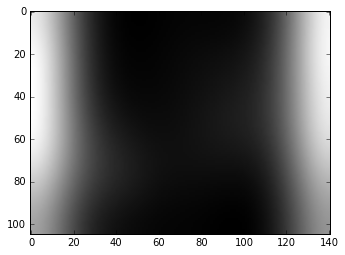

In [7]:
from scipy.ndimage import filters
GFil_1=[] #12*L*W
for im,sig in zip(F1filtered,sigma):
    GFil_1.append(filters.gaussian_filter(im,sig))
plt.imshow(GFil_1[0])
plt.show()

### Combine features

In [8]:
GFil_1=np.array(GFil_1)
GFil_1=GFil_1.reshape(12,-1) # reshape to 2D
GFil_1=GFil_1.transpose()
GFil_1.shape

(14805, 12)

In [9]:
plt.close()

### Kmeans

In [10]:
from sklearn.cluster import KMeans
est =KMeans(n_clusters=6)
est.fit(GFil_1)
labels = est.labels_

### Plot classes

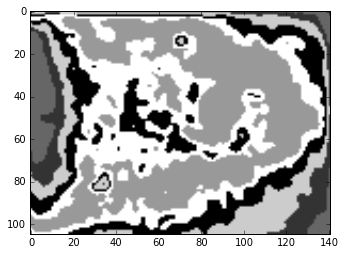

In [11]:
labels = labels.reshape(105,141)
%matplotlib inline
_=plt.imshow(labels)

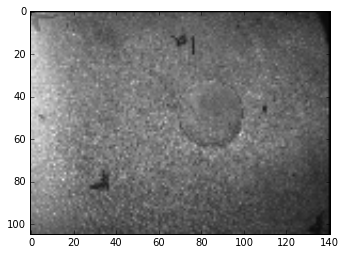

In [12]:
%matplotlib inline
_=plt.imshow(F[0])

### Compute features of one MSI

In [ ]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats
# features
MSI_feats=[compute_feats(im, kernels) for im in F]
#MSI_feats is of size 8*12*2

MSI=MSI_feats[]

In [ ]:
len(MSI_feats[0][0])